<a href="https://colab.research.google.com/github/kdh4672/economy_ai/blob/main/EC5320_2022_Week5a_CNN_categorization_gender_imdb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#EC5320 Week4a codes: CNN regression (Age detection) - FOR TEACHING

2022.3.23.<br>

Author: Hyunjoo Yang (hyang@sogang.ac.kr)<br><br>

This notebook uses CNN to do age prediction.<br><br>

Data source for face images: <br>
https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ <br><br>

Codes are based on: <br>
https://medium.com/analytics-vidhya/fastai-image-regression-age-prediction-based-on-image-68294d34f2ed <br><br>

For image augmentation, refer to: <br>
https://github.com/fastai/fastbook/blob/master/02_production.ipynb <br><br>

For AI and ethics, refer to: <br>
https://github.com/fastai/fastbook/blob/master/03_ethics.ipynb <br><br>

# 1. Install and import libraries

In [ ]:
# upgrade fastai to the most recent version (v. 2.5.3)

%%capture
!pip install fastai --upgrade

In [ ]:
import fastai
print(fastai.__version__)

from fastai.vision.all import *
#from fastai.text.all import *
#from fastai.collab import *
#from fastai.tabular.all import * 

from matplotlib.pyplot import imshow

2.5.5


In [ ]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import imshow
from google.colab import files

# 2. Download file

In [ ]:
!wget -O df_imdb_full.csv 'https://www.dropbox.com/s/wwp5a782i61bvli/df_imdb_full.csv?dl=0'

--2022-03-30 01:59:56--  https://www.dropbox.com/s/wwp5a782i61bvli/df_imdb_full.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/wwp5a782i61bvli/df_imdb_full.csv [following]
--2022-03-30 01:59:56--  https://www.dropbox.com/s/raw/wwp5a782i61bvli/df_imdb_full.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucb7fdb8dd5b18f4e280c394c005.dl.dropboxusercontent.com/cd/0/inline/Bia4-VwCR7kc1_lVLoeIUsqB0CrvmCvO-ltaHP3p1qydY0M4ATixygdI68iWLLEfGm0Z5Ia50gDwDYnbz0VodnTrPqYN8XhJHtmgDaNt9JIKd5bm39ZAU6SxCXEMB1XxxfHv1mGW0FlFrLdTg2hNNscEAHgCp52Z8Bg5qGDU2x3w4A/file# [following]
--2022-03-30 01:59:57--  https://ucb7fdb8dd5b18f4e280c394c005.dl.dropboxusercontent.com/cd/0/inline/Bia4-VwCR7kc1_lVLoeIUsqB0CrvmCvO-ltaHP3p1qydY0M4

In [ ]:
!wget -O imdb_crop_sample.zip 'https://www.dropbox.com/s/alphyo3ofqsy5ff/imdb_crop_sample.zip?dl=0'

--2022-03-30 02:06:43--  https://www.dropbox.com/s/alphyo3ofqsy5ff/imdb_crop_sample.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.67.18, 2620:100:6023:18::a27d:4312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.67.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/alphyo3ofqsy5ff/imdb_crop_sample.zip [following]
--2022-03-30 02:06:43--  https://www.dropbox.com/s/raw/alphyo3ofqsy5ff/imdb_crop_sample.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc626d61650f63c5f0021bd535f7.dl.dropboxusercontent.com/cd/0/inline/BiYABcvHfiMuYL8O4zXYJmYB9DNkYZazweJi0OCyieJfMYTY9qA33c7NfnmtCsQZghEtZZAQN88cPswHfS_N_-B0JW8UURUXRwXv6ImWMGF_mujr-4rSGvignhUCaKPpCh5dCU9m5hETpRdh1wOudvYoIQPaSZc5tecmnUKknofoDQ/file# [following]
--2022-03-30 02:06:44--  https://uc626d61650f63c5f0021bd535f7.dl.dropboxusercontent.com/cd/0/inline/BiYABcvHfiMuYL8O4zXYJmYB9DNkYZazweJi

In [ ]:
!unzip imdb_crop_sample.zip

In [ ]:
!mkdir faces

In [ ]:
!mv *.jpg faces/.

In [ ]:
!mv imdb.mat faces/.

# 3. Prepare image file path + label dataframe

## 3.1 grab image file paths

In [ ]:
# *** CHANGE directory and file extension HERE ***

where_and_what_to_search = 'faces/*.jpg' # YOUR IMAGE SUBFOLDER / IMAGE FILE EXTENSION

# grab image file paths

import glob
img_full_path = pd.Series(glob.glob(where_and_what_to_search), name='my_file_path')
img_nm = pd.Series(img_full_path.str.split(pat="/").str[1], name='file_nm')

df_imdb_sample = pd.concat([img_full_path, img_nm], axis=1)
df_imdb_sample

,my_file_path,file_nm
0,faces/nm2107620_rm1201664000_1986-10-12_2010.jpg,nm2107620_rm1201664000_1986-10-12_2010.jpg
1,faces/nm0721205_rm3834755584_1972-1-15_1993.jpg,nm0721205_rm3834755584_1972-1-15_1993.jpg
2,faces/nm0000413_rm1387370496_1964-9-28_2007.jpg,nm0000413_rm1387370496_1964-9-28_2007.jpg
3,faces/nm1385871_rm935177728_1979-11-14_2012.jpg,nm1385871_rm935177728_1979-11-14_2012.jpg
4,faces/nm0000131_rm1697683456_1966-6-28_2007.jpg,nm0000131_rm1697683456_1966-6-28_2007.jpg
...,...,...
4995,faces/nm0958969_rm3675161600_1965-7-1_2003.jpg,nm0958969_rm3675161600_1965-7-1_2003.jpg
4996,faces/nm0001007_rm3586955520_1937-1-4_2005.jpg,nm0001007_rm3586955520_1937-1-4_2005.jpg
4997,faces/nm0225269_rm690985472_1952-8-23_2006.jpg,nm0225269_rm690985472_1952-8-23_2006.jpg
4998,faces/nm3210795_rm4000108032_1979-4-29_2009.jpg,nm3210795_rm4000108032_1979-4-29_2009.jpg


## 3.2 grab ground truth dataset (MATLAB data)

In [ ]:
import scipy.io
mat_imdb = scipy.io.loadmat('faces/imdb.mat')

In [ ]:
# get 'dob', 'photo_taken', 'gender'

mat_imdb_2nd_layer = mat_imdb['imdb'][0][0]

df_dob = pd.Series(mat_imdb_2nd_layer[0][0], name='dob')
df_photo_taken = pd.Series(mat_imdb_2nd_layer[1][0], name='photo_taken')
df_gender = pd.Series(mat_imdb_2nd_layer[3][0], name='gender')

In [ ]:
# get image file full path 

full_path = []
for i in range(len(mat_imdb_2nd_layer[2][0])):
    full_path.append(mat_imdb_2nd_layer[2][0][i][0])

In [ ]:
df_full_path = pd.Series(full_path, name='full_path')

In [ ]:
# concat all together

df_imdb_full = pd.concat([df_dob, df_photo_taken, df_full_path, df_gender], axis=1)
df_imdb_full

,dob,photo_taken,full_path,gender
0,693726,1968,01/nm0000001_rm124825600_1899-5-10_1968.jpg,1.0
1,693726,1970,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,1.0
2,693726,1968,01/nm0000001_rm577153792_1899-5-10_1968.jpg,1.0
3,693726,1968,01/nm0000001_rm946909184_1899-5-10_1968.jpg,1.0
4,693726,1968,01/nm0000001_rm980463616_1899-5-10_1968.jpg,1.0
...,...,...,...,...
460718,726831,2011,08/nm3994408_rm761245696_1989-12-29_2011.jpg,0.0
460719,726831,2011,08/nm3994408_rm784182528_1989-12-29_2011.jpg,0.0
460720,726831,2011,08/nm3994408_rm926592512_1989-12-29_2011.jpg,0.0
460721,726831,2011,08/nm3994408_rm943369728_1989-12-29_2011.jpg,0.0


In [ ]:
from datetime import datetime, timedelta

def datenum_to_datetime(datenum):
    
    try:
        days = datenum % 1
        hours = days % 1 * 24
        minutes = hours % 1 * 60
        seconds = minutes % 1 * 60
        exact_date = datetime.fromordinal(int(datenum)) \
           + timedelta(days=int(days)) \
           + timedelta(hours=int(hours)) \
           + timedelta(minutes=int(minutes)) \
           + timedelta(seconds=round(seconds)) \
           - timedelta(days=366)
    
        return exact_date.year
    
    except(ValueError, TypeError, OverflowError):
        
        return np.nan  

In [ ]:
# calculate date of birth

df_imdb_full['date_of_birth'] = df_imdb_full['dob'].apply(datenum_to_datetime)
df_imdb_full

,dob,photo_taken,full_path,gender,date_of_birth,file_nm
0,693726,1968,01/nm0000001_rm124825600_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm124825600_1899-5-10_1968.jpg
1,693726,1970,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,1.0,1899.0,nm0000001_rm3343756032_1899-5-10_1970.jpg
2,693726,1968,01/nm0000001_rm577153792_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm577153792_1899-5-10_1968.jpg
3,693726,1968,01/nm0000001_rm946909184_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm946909184_1899-5-10_1968.jpg
4,693726,1968,01/nm0000001_rm980463616_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm980463616_1899-5-10_1968.jpg
...,...,...,...,...,...,...
460718,726831,2011,08/nm3994408_rm761245696_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm761245696_1989-12-29_2011.jpg
460719,726831,2011,08/nm3994408_rm784182528_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm784182528_1989-12-29_2011.jpg
460720,726831,2011,08/nm3994408_rm926592512_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm926592512_1989-12-29_2011.jpg
460721,726831,2011,08/nm3994408_rm943369728_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm943369728_1989-12-29_2011.jpg


In [ ]:
# extract filename without directory info

df_imdb_full['file_nm'] = df_imdb_full['full_path'].str.split(pat="/").str[1]
df_imdb_full

,dob,photo_taken,full_path,gender,date_of_birth,file_nm
0,693726,1968,01/nm0000001_rm124825600_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm124825600_1899-5-10_1968.jpg
1,693726,1970,01/nm0000001_rm3343756032_1899-5-10_1970.jpg,1.0,1899.0,nm0000001_rm3343756032_1899-5-10_1970.jpg
2,693726,1968,01/nm0000001_rm577153792_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm577153792_1899-5-10_1968.jpg
3,693726,1968,01/nm0000001_rm946909184_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm946909184_1899-5-10_1968.jpg
4,693726,1968,01/nm0000001_rm980463616_1899-5-10_1968.jpg,1.0,1899.0,nm0000001_rm980463616_1899-5-10_1968.jpg
...,...,...,...,...,...,...
460718,726831,2011,08/nm3994408_rm761245696_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm761245696_1989-12-29_2011.jpg
460719,726831,2011,08/nm3994408_rm784182528_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm784182528_1989-12-29_2011.jpg
460720,726831,2011,08/nm3994408_rm926592512_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm926592512_1989-12-29_2011.jpg
460721,726831,2011,08/nm3994408_rm943369728_1989-12-29_2011.jpg,0.0,1989.0,nm3994408_rm943369728_1989-12-29_2011.jpg


## 3.3 Merge my image file df with ground truth data

In [ ]:
# merge ground truth data

df_imdb = pd.merge(df_imdb_sample, df_imdb_full)
# df_imdb = df_imdb_full
df_imdb

,my_file_path,file_nm,dob,photo_taken,full_path,gender,date_of_birth
0,faces/nm2107620_rm1201664000_1986-10-12_2010.jpg,nm2107620_rm1201664000_1986-10-12_2010.jpg,725657,2010,20/nm2107620_rm1201664000_1986-10-12_2010.jpg,1.0,1986.0
1,faces/nm0721205_rm3834755584_1972-1-15_1993.jpg,nm0721205_rm3834755584_1972-1-15_1993.jpg,720273,1993,05/nm0721205_rm3834755584_1972-1-15_1993.jpg,1.0,1972.0
2,faces/nm0000413_rm1387370496_1964-9-28_2007.jpg,nm0000413_rm1387370496_1964-9-28_2007.jpg,717608,2007,13/nm0000413_rm1387370496_1964-9-28_2007.jpg,0.0,1964.0
3,faces/nm1385871_rm935177728_1979-11-14_2012.jpg,nm1385871_rm935177728_1979-11-14_2012.jpg,723133,2012,71/nm1385871_rm935177728_1979-11-14_2012.jpg,0.0,1979.0
4,faces/nm0000131_rm1697683456_1966-6-28_2007.jpg,nm0000131_rm1697683456_1966-6-28_2007.jpg,718246,2007,31/nm0000131_rm1697683456_1966-6-28_2007.jpg,1.0,1966.0
...,...,...,...,...,...,...,...
4995,faces/nm0958969_rm3675161600_1965-7-1_2003.jpg,nm0958969_rm3675161600_1965-7-1_2003.jpg,717884,2003,69/nm0958969_rm3675161600_1965-7-1_2003.jpg,1.0,1965.0
4996,faces/nm0001007_rm3586955520_1937-1-4_2005.jpg,nm0001007_rm3586955520_1937-1-4_2005.jpg,707479,2005,07/nm0001007_rm3586955520_1937-1-4_2005.jpg,0.0,1937.0
4997,faces/nm0225269_rm690985472_1952-8-23_2006.jpg,nm0225269_rm690985472_1952-8-23_2006.jpg,713189,2006,69/nm0225269_rm690985472_1952-8-23_2006.jpg,NaN,1952.0
4998,faces/nm3210795_rm4000108032_1979-4-29_2009.jpg,nm3210795_rm4000108032_1979-4-29_2009.jpg,722934,2009,95/nm3210795_rm4000108032_1979-4-29_2009.jpg,1.0,1979.0


In [ ]:
# check if missing variable
df_imdb.isnull().sum()

my_file_path      0
file_nm           0
dob               0
photo_taken       0
full_path         0
gender           92
date_of_birth     1
dtype: int64

In [ ]:
# delete NaN sample
df_imdb = df_imdb.replace([np.inf, -np.inf], np.nan)
df_imdb.dropna(inplace=True)

In [ ]:
# check if missing variable
df_imdb.isnull().sum()

my_file_path     0
file_nm          0
dob              0
photo_taken      0
full_path        0
gender           0
date_of_birth    0
dtype: int64

In [ ]:
df_imdb.shape

(4907, 7)

## 3.4 Calculate age

In [ ]:
# calculate age
df_imdb['age'] = df_imdb['photo_taken'] - df_imdb['date_of_birth']

# some guys seem to be greater than 100. some of these are paintings. remove these old guys
df_imdb = df_imdb[df_imdb['age'] <= 100]

# some guys seem to be unborn in the data set
df_imdb = df_imdb[df_imdb['age'] > 0]

In [ ]:
df_imdb.shape

(4902, 8)

In [ ]:
df_imdb

,my_file_path,file_nm,dob,photo_taken,full_path,gender,date_of_birth,age
0,faces/nm2107620_rm1201664000_1986-10-12_2010.jpg,nm2107620_rm1201664000_1986-10-12_2010.jpg,725657,2010,20/nm2107620_rm1201664000_1986-10-12_2010.jpg,1.0,1986.0,24.0
1,faces/nm0721205_rm3834755584_1972-1-15_1993.jpg,nm0721205_rm3834755584_1972-1-15_1993.jpg,720273,1993,05/nm0721205_rm3834755584_1972-1-15_1993.jpg,1.0,1972.0,21.0
2,faces/nm0000413_rm1387370496_1964-9-28_2007.jpg,nm0000413_rm1387370496_1964-9-28_2007.jpg,717608,2007,13/nm0000413_rm1387370496_1964-9-28_2007.jpg,0.0,1964.0,43.0
3,faces/nm1385871_rm935177728_1979-11-14_2012.jpg,nm1385871_rm935177728_1979-11-14_2012.jpg,723133,2012,71/nm1385871_rm935177728_1979-11-14_2012.jpg,0.0,1979.0,33.0
4,faces/nm0000131_rm1697683456_1966-6-28_2007.jpg,nm0000131_rm1697683456_1966-6-28_2007.jpg,718246,2007,31/nm0000131_rm1697683456_1966-6-28_2007.jpg,1.0,1966.0,41.0
...,...,...,...,...,...,...,...,...
4994,faces/nm0000163_rm2391723008_1937-8-8_1987.jpg,nm0000163_rm2391723008_1937-8-8_1987.jpg,707695,1987,63/nm0000163_rm2391723008_1937-8-8_1987.jpg,1.0,1937.0,50.0
4995,faces/nm0958969_rm3675161600_1965-7-1_2003.jpg,nm0958969_rm3675161600_1965-7-1_2003.jpg,717884,2003,69/nm0958969_rm3675161600_1965-7-1_2003.jpg,1.0,1965.0,38.0
4996,faces/nm0001007_rm3586955520_1937-1-4_2005.jpg,nm0001007_rm3586955520_1937-1-4_2005.jpg,707479,2005,07/nm0001007_rm3586955520_1937-1-4_2005.jpg,0.0,1937.0,68.0
4998,faces/nm3210795_rm4000108032_1979-4-29_2009.jpg,nm3210795_rm4000108032_1979-4-29_2009.jpg,722934,2009,95/nm3210795_rm4000108032_1979-4-29_2009.jpg,1.0,1979.0,30.0


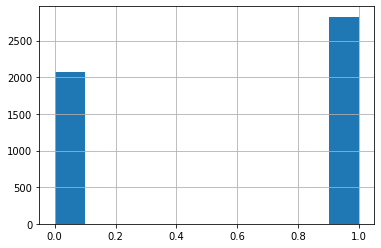

In [ ]:
df_imdb['gender'].hist()

# 9. Prepare data for CNN

In [ ]:
# data block settings

my_random_seed = 42
my_batch_size = 64
df_imdb

,my_file_path,file_nm,dob,photo_taken,full_path,gender,date_of_birth,age
0,faces/nm2107620_rm1201664000_1986-10-12_2010.jpg,nm2107620_rm1201664000_1986-10-12_2010.jpg,725657,2010,20/nm2107620_rm1201664000_1986-10-12_2010.jpg,1.0,1986.0,24.0
1,faces/nm0721205_rm3834755584_1972-1-15_1993.jpg,nm0721205_rm3834755584_1972-1-15_1993.jpg,720273,1993,05/nm0721205_rm3834755584_1972-1-15_1993.jpg,1.0,1972.0,21.0
2,faces/nm0000413_rm1387370496_1964-9-28_2007.jpg,nm0000413_rm1387370496_1964-9-28_2007.jpg,717608,2007,13/nm0000413_rm1387370496_1964-9-28_2007.jpg,0.0,1964.0,43.0
3,faces/nm1385871_rm935177728_1979-11-14_2012.jpg,nm1385871_rm935177728_1979-11-14_2012.jpg,723133,2012,71/nm1385871_rm935177728_1979-11-14_2012.jpg,0.0,1979.0,33.0
4,faces/nm0000131_rm1697683456_1966-6-28_2007.jpg,nm0000131_rm1697683456_1966-6-28_2007.jpg,718246,2007,31/nm0000131_rm1697683456_1966-6-28_2007.jpg,1.0,1966.0,41.0
...,...,...,...,...,...,...,...,...
4994,faces/nm0000163_rm2391723008_1937-8-8_1987.jpg,nm0000163_rm2391723008_1937-8-8_1987.jpg,707695,1987,63/nm0000163_rm2391723008_1937-8-8_1987.jpg,1.0,1937.0,50.0
4995,faces/nm0958969_rm3675161600_1965-7-1_2003.jpg,nm0958969_rm3675161600_1965-7-1_2003.jpg,717884,2003,69/nm0958969_rm3675161600_1965-7-1_2003.jpg,1.0,1965.0,38.0
4996,faces/nm0001007_rm3586955520_1937-1-4_2005.jpg,nm0001007_rm3586955520_1937-1-4_2005.jpg,707479,2005,07/nm0001007_rm3586955520_1937-1-4_2005.jpg,0.0,1937.0,68.0
4998,faces/nm3210795_rm4000108032_1979-4-29_2009.jpg,nm3210795_rm4000108032_1979-4-29_2009.jpg,722934,2009,95/nm3210795_rm4000108032_1979-4-29_2009.jpg,1.0,1979.0,30.0


In [ ]:
from fastai.vision.data import ImageDataLoaders

In [ ]:
df_imdb_simple = df_imdb[['my_file_path','gender']]
df_imdb_simple

,my_file_path,gender
0,faces/nm2107620_rm1201664000_1986-10-12_2010.jpg,1.0
1,faces/nm0721205_rm3834755584_1972-1-15_1993.jpg,1.0
2,faces/nm0000413_rm1387370496_1964-9-28_2007.jpg,0.0
3,faces/nm1385871_rm935177728_1979-11-14_2012.jpg,0.0
4,faces/nm0000131_rm1697683456_1966-6-28_2007.jpg,1.0
...,...,...
4994,faces/nm0000163_rm2391723008_1937-8-8_1987.jpg,1.0
4995,faces/nm0958969_rm3675161600_1965-7-1_2003.jpg,1.0
4996,faces/nm0001007_rm3586955520_1937-1-4_2005.jpg,0.0
4998,faces/nm3210795_rm4000108032_1979-4-29_2009.jpg,1.0


In [ ]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('gender'),
    splitter=RandomSplitter(valid_pct=0.2, seed=my_random_seed),
    item_tfms=Resize(128)
).dataloaders(df_imdb_simple)

In [ ]:
len(dls.train_ds), len(dls.valid_ds)

(3922, 980)

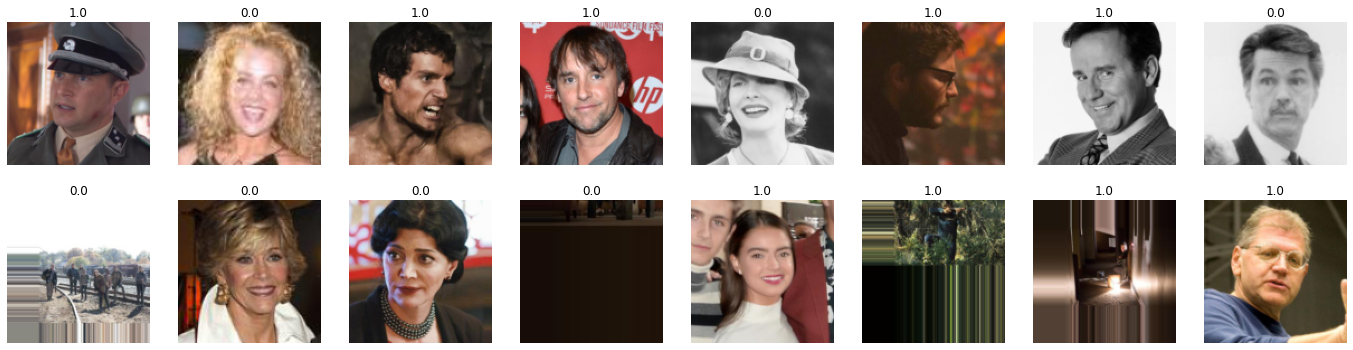

In [ ]:
# show image examples

dls.show_batch(max_n=16, nrows=2)

# 10. Train CNN model

In [ ]:
learn = cnn_learner(dls, resnet18, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(1)

epoch,train_loss,valid_loss,accuracy,time
0,1.042363,0.842230,0.681633,00:24


epoch,train_loss,valid_loss,accuracy,time
0,0.766764,0.656358,0.724490,00:26


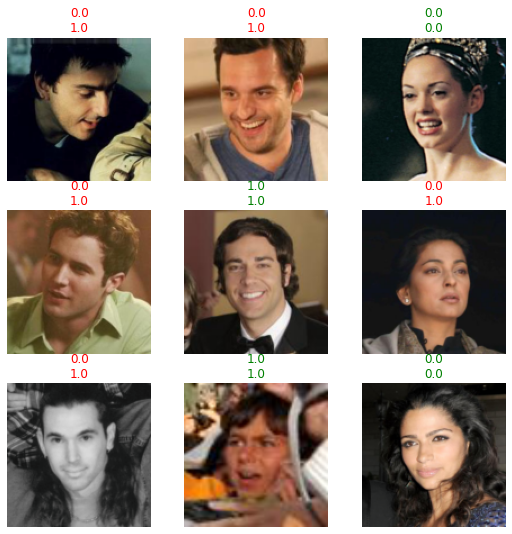

In [ ]:
learn.show_results()

# 11. Test using your own image

In [ ]:
from google.colab import files

In [ ]:
# upload an image file

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file: {name}'.format(name=fn))

In [ ]:
# get the file name of the uploaded file 

img_name = list(uploaded.keys())[0]

In [ ]:
# predict

img = PILImage.create(uploaded[img_name])

img.show()

In [ ]:
learn.predict(img)

# 12. Image augmentation

## 12.1 Radome Resized Crop

In [ ]:
dls_aug = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('gender'),
    splitter=RandomSplitter(valid_pct=0.2, seed=my_random_seed),
    item_tfms=RandomResizedCrop(128, min_scale=0.7)
).dataloaders(df_imdb_simple)

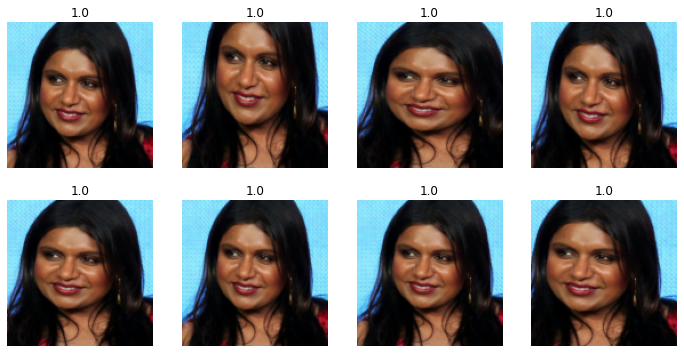

In [ ]:
dls_aug.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls_aug, resnet34, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(15)

## 12.2 aug_transforms

In [ ]:
dls_aug2 = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_x=ColReader('my_file_path'), 
    get_y=ColReader('gender'),
    splitter=RandomSplitter(valid_pct=0.2, seed=my_random_seed),
    item_tfms=Resize(128),
    batch_tfms=aug_transforms(mult=2)
).dataloaders(df_imdb_simple)

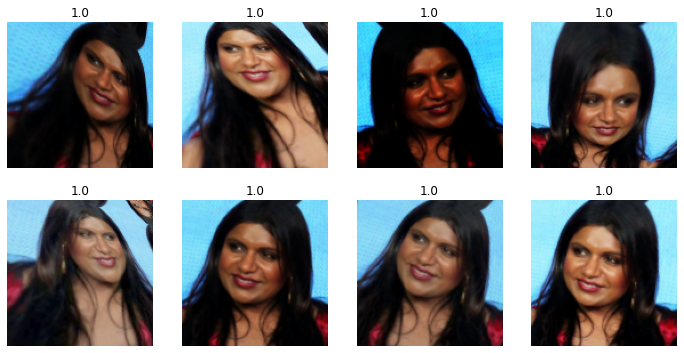

In [ ]:
dls_aug2.train.show_batch(max_n=8, nrows=2, unique=True)

In [ ]:
learn = cnn_learner(dls_aug2, resnet34, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.fine_tune(15)

epoch,train_loss,valid_loss,accuracy,time
0,1.048312,0.748428,0.677551,00:31


epoch,train_loss,valid_loss,accuracy,time
0,0.846524,0.666502,0.716327,00:28
1,0.750662,0.632836,0.731633,00:29
2,0.746472,0.608212,0.712245,00:29


KeyboardInterrupt: ignored

# 13. Early stopping

In [ ]:
learn.validate()

epoch,train_loss,valid_loss,accuracy,time
0,0.846524,0.666502,0.716327,00:28
1,0.750662,0.632836,0.731633,00:29
2,0.746472,0.608212,0.712245,00:29


(#2) [0.5624544620513916,0.7234693765640259]

In [ ]:
learn = cnn_learner(dls_aug2, resnet34, metrics=accuracy).to_fp16() # resnet 18, 34, 50, 101, 152
learn.path = Path('./')
learn.fine_tune(50, cbs=[EarlyStoppingCallback(monitor='valid_loss', patience=3),SaveModelCallback(monitor='valid_loss')])

epoch,train_loss,valid_loss,accuracy,time
0,1.041762,0.757088,0.700000,00:27


Better model found at epoch 0 with valid_loss value: 0.7570882439613342.


epoch,train_loss,valid_loss,accuracy,time
0,0.846723,0.655114,0.712245,00:33
1,0.755587,0.629627,0.733673,00:29
2,0.713391,0.628139,0.728571,00:28
3,0.659261,0.619073,0.719388,00:29
4,0.639646,0.631193,0.706122,00:29


Better model found at epoch 0 with valid_loss value: 0.6551139950752258.
Better model found at epoch 1 with valid_loss value: 0.6296265721321106.
Better model found at epoch 2 with valid_loss value: 0.628139078617096.
Better model found at epoch 3 with valid_loss value: 0.6190734505653381.


In [ ]:
learn.validate()

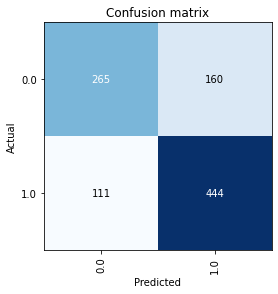

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()